# Assessment of Aidan Kelley's Problem 2

In [1]:
import math
import torch
import gpytorch
import gc
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.manual_seed(40)
np.random.seed(40)

In [14]:
# f(x) = g1(A1*x1) + g2(A2*x2)
# f(-1,1,2) = 2
# f(0,1,-2) = 2
# f(-2,2,-1) = 3
# f(-2,0,-2) = 1
# f(2,1,1) = 2
# x1 = (a,b)
# x2 = (c)

trainPoints = [
    [-1,1,2],
    [0,1,-2],
    [-2,2,-1],
    [-2,0,-2],
    [2,1,1]
]

trainVals = [2, 2, 3, 1, 2]

train_x = torch.tensor(trainPoints)
train_y = torch.tensor(trainVals)

A1 = torch.rand(2,2)
A2 = torch.rand(1)

In [22]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x, kronecker_structure=False)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.AdditiveStructureKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.GridInterpolationKernel(
                    gpytorch.kernels.RBFKernel(), grid_size=128, num_dims=1
                )
            ), num_dims=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = GPRegressionModel(train_x, train_y, likelihood).cuda()

In [23]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train(training_iterations):
    for i in range(training_iterations):
        clear_output(wait=True)
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        display('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

In [25]:
train(1000)

'Iter 1000/1000 - Loss: 0.961'

In [43]:
# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Generate nxn grid of test points spaced on a grid of size 1/(n-1) in [0,1]x[0,1]
test_x = torch.FloatTensor(100, 3).uniform_(-5, 5).long().cuda()

In [44]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(10, 10)

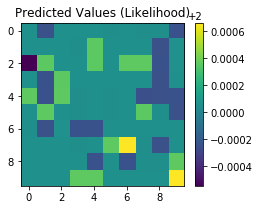

In [46]:
n=10

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels.cpu())
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')


In [51]:
model(test_x).mean

tensor([2.0001, 1.9998, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        1.9998, 2.0001, 2.0001, 2.0001, 2.0001, 2.0004, 2.0001, 2.0001, 2.0001,
        1.9998, 2.0001, 1.9995, 2.0004, 2.0001, 2.0001, 2.0004, 2.0001, 2.0004,
        2.0004, 1.9998, 2.0001, 2.0001, 1.9998, 2.0004, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 1.9998, 2.0001, 2.0004, 1.9998, 2.0004, 2.0001, 2.0001,
        2.0001, 2.0001, 1.9998, 1.9998, 1.9998, 2.0001, 2.0004, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0004, 2.0001, 1.9998, 2.0001, 1.9998, 2.0001,
        1.9998, 1.9998, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0004, 2.0007, 2.0001, 1.9998, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 1.9998, 2.0001, 1.9998, 2.0001, 2.0001, 2.0004,
        2.0001, 2.0001, 2.0001, 2.0004, 2.0004, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0007], grad_fn=<ViewBackward>)

# Reflection

Honestly I have no clude if I was even close to going in the right direction on this one. I tried to implement using GPytorch, but after going through, I don't think that was the right choice. I really would have appreciated some starter or skeleton code that it would then be my job to fill in, as that would have changed the problem from figuring out what I'm even supposed to do at all to learning implementation of a GAM. The way the problem was worded made it fairly difficult to understand what exactly I was supposed to do, but maybe this was due to a knowledge gap on my part, I'm not really sure. In terms of scope, I felt that although the problem was fairly narrow in scope, it would have been very good for learning about GAMs if only there was a little bit more help provided.